# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
file_name = 'tab_tick'
#file_name = 'full_tab_tick'

In [5]:
df = pd.read_csv('data/'+file_name+'_2019.csv')
#df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,spread_cls_diff,tick_opn_diff,tick_high_diff,tick_low_diff,tick_cls_diff,tick_avg_diff,tick_sd,tick_ema_10_diff,tick_ema_25_diff,...,tick_ema_75_diff,tick_ema_diff,ema_gap,gain,loss,avg_gain,avg_loss,rsi,tick_slope,direction
0,0.000405,0.00025,0.000025,0.000130,-0.000020,0.000055,0.000035,0.000060,0.000056,0.000071,...,0.000063,0.000053,0.000003,0.000035,0.000000,0.000019,0.000033,36.630037,8.526058,same
1,0.000531,-0.00029,0.000050,0.000065,0.000030,0.000145,0.000057,0.000058,0.000099,0.000021,...,0.000010,0.000027,0.000072,0.000057,0.000000,0.000023,0.000033,41.189802,-3.724729,decrease
2,0.000375,0.00012,0.000145,-0.000010,-0.000275,-0.000430,-0.000132,0.000125,-0.000373,-0.000296,...,-0.000204,-0.000179,-0.000194,0.000000,0.000132,0.000023,0.000043,35.201212,-19.796746,same
3,0.000522,0.00025,-0.000400,-0.000305,-0.000005,-0.000045,-0.000201,0.000065,-0.000097,-0.000086,...,-0.000144,-0.000164,0.000066,0.000000,0.000201,0.000023,0.000043,35.277537,-6.967128,same
4,0.000633,0.00014,-0.000055,-0.000015,-0.000010,0.000070,0.000020,0.000056,0.000092,0.000068,...,0.000061,0.000045,0.000047,0.000020,0.000000,0.000025,0.000037,39.812039,3.870720,increase


In [6]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 9987
--------------------------
same        7887
decrease    1071
increase    1029
Name: direction, dtype: int64
--------------------------
same        0.789727
decrease    0.107239
increase    0.103034
Name: direction, dtype: float64


['data/model/y_map.pkl']

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Random Forest

In [8]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
joblib.dump(clf, 'data/model/model_rf.pkl') 

predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.27      0.15      0.19       208
    increase       0.20      0.00      0.01       204
        same       0.82      0.97      0.88      1586

    accuracy                           0.78      1998
   macro avg       0.43      0.37      0.36      1998
weighted avg       0.70      0.78      0.72      1998

Wall time: 941 ms


Record count : 9987
--------------------------
same        6154
increase    1930
decrease    1903
Name: direction, dtype: int64
--------------------------
same        0.616201
increase    0.193251
decrease    0.190548
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.35      0.13      0.19      1903
    increase       0.57      0.01      0.01      1930
        same       0.64      0.96      0.77      6154

    accuracy                           0.62      9987
   macro avg       0.52      0.37      0.32      9987
weighted avg       0.57      0.62      0.51      9987



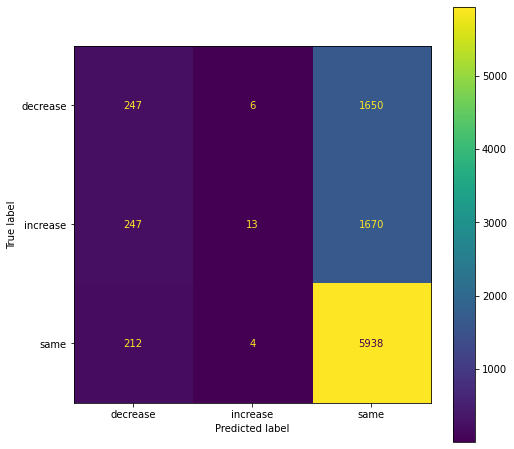

In [10]:
df1 = pd.read_csv('data/'+file_name+'_2018.csv')
#df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_rf = joblib.load('data/model/model_rf.pkl') 
predictions = clf_rf.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

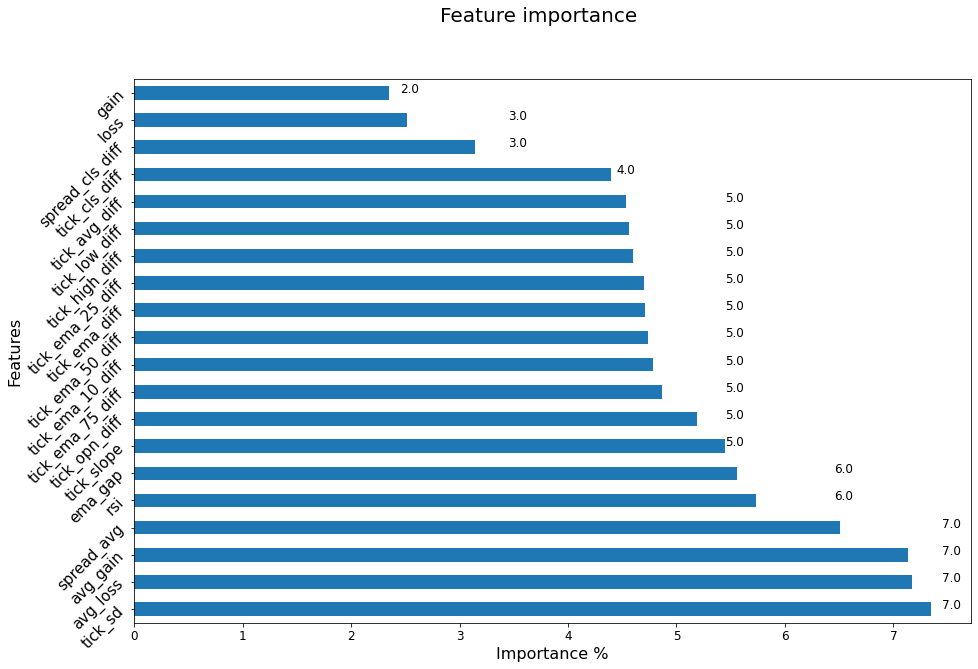

In [11]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf_rf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_rf.predict(x_scaled)

rounded_predictions = np.argmax(predictions, axis = -1)

live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

In [11]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)